# pandas exercises

We'll use the sample datset from the Social Secury Administration on baby names:
https://www.ssa.gov/oact/babynames/limits.html

Download the "National" version and unzip it.  There will be one file for each year.

This example follows the _Python for Data Analysis_ book closely

In [13]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Let's start by reading in just a single dataset, for the first year available (1880).  We give the names of the colums here.  The index will just be the line / record number in the file (not really important for us)

In [14]:
names_1976 = pd.read_csv('names/yob1976.txt', names=["name", "sex", "births"])
names_1976

,name,sex,births
0,Jennifer,F,59474
1,Amy,F,31341
2,Melissa,F,25093
3,Heather,F,24199
4,Angela,F,22041
...,...,...,...
17386,Zacharie,M,5
17387,Zebulun,M,5
17388,Zedric,M,5
17389,Zee,M,5


## number of births

Now we want to start doing some analysis.  `.groupby()` creates a new type of container that groups items.  Here, we'll group by sex.

See this:
http://pandas.pydata.org/pandas-docs/stable/groupby.html
https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/

for a nice explanation of this method.

In [15]:
names_1976.groupby("sex")["births"].sum()

sex
F    1465106
M    1569843
Name: births, dtype: int64

Note that we can use a column name as a parameter of the object, so we can equivalently do this as:

In [16]:
names_1976.groupby("sex").births.sum()

sex
F    1465106
M    1569843
Name: births, dtype: int64

On its own, you can't print a `GroupBy` object.  You need to do a transformation or filter on it to get back a `Series` or `DataFrame`.

In [17]:
gb = names_1976.groupby("sex")
gb.count()

,name,births
sex,,
F,10900,10900
M,6491,6491


As we saw in the intro, we can propagate a scalar to all indices in the `DataFrame`.  We'll use this to add a new column that represents the year:

In [18]:
names_1880["year"] = 1880
names_1880

NameError: name 'names_1880' is not defined

## all data sets

Now we can read in all of the datasets.  We will read them in one-by-one and add the "year" column to them.  We'll keep a list of all the `DataFrame`s and then we'll use a pandas method to transform this list of `DataFrame`s into a single `DataFrame`

In [19]:
years = range(1880, 2018)

pieces = []
columns = ["name", "sex", "births"]

for yr in years:
    frame = pd.read_csv("names/yob{}.txt".format(yr), names=columns)
    
    # this creates a new column and gives all rows the same value -- the year
    frame["year"] = yr
    pieces.append(frame)

# create a single dataframe through concatenation -- ignore_index means that
# we don't care about the original line numbers
names = pd.concat(pieces, ignore_index=True)

In [20]:
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1924660,Zykai,M,5,2017
1924661,Zykeem,M,5,2017
1924662,Zylin,M,5,2017
1924663,Zylis,M,5,2017


## pivot tables

a _pivot table_ creates a new dataframe from our orignal one, usually summarizing the data in a new way.  In particular, with a pivot table, we can create a new index and columns, with the data in the `DataFrame` reduced via some operation across another column.

Here, the column that we are going to aggregrate is "births", and the function will will use for the aggregating is `sum` (to sum over the names).

In [21]:
names.sample(10)

,name,sex,births,year
1073664,Kelcee,F,25,1990
1304411,Whitney,F,1426,1999
526144,Ramey,M,5,1955
1529421,Leidi,F,11,2006
1061150,Brant,M,165,1989
1674496,Samriddhi,F,6,2010
737382,Thor,M,64,1972
1024021,Kaila,F,391,1988
1228977,Antonique,F,15,1996
876141,Mitchell,M,1522,1980


In [22]:
total_births = names.pivot_table("births", index="year", columns="sex", aggfunc=sum)

In [23]:
total_births

sex,F,M
year,,
1880,90993,110491
1881,91953,100743
1882,107847,113686
1883,112319,104627
1884,129020,114442
...,...,...
2013,1750321,1886989
2014,1781072,1915239
2015,1778883,1909804


<AxesSubplot:xlabel='year'>

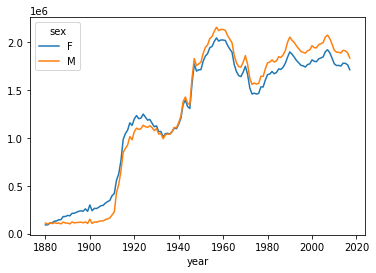

In [24]:
total_births.plot()

## `.apply()` and new columns

Now we'll use `.groupby()` again to allow use to derive a new column -- the fraction of the births with the name specified by the index.  

`apply()` uses what Pandas calls the _split-apply-combine_ rules, e.g., it splits the data into groups, applies your function, and then intelligently concatenates it back together.  Here, the result will be a `DataFrame` with the original information and this new column.

In [35]:
def add_prop(group):
    group["prop"] = group["births"]/group["births"].sum()
    return group

names = names.groupby(["year", "sex"]).apply(add_prop)

In [36]:
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1924660,Zykai,M,5,2017,0.000003
1924661,Zykeem,M,5,2017,0.000003
1924662,Zylin,M,5,2017,0.000003
1924663,Zylis,M,5,2017,0.000003


## Q1: Sanity check

Verify that within each of the groups we just used above that the "prop" column sums to 1 (it should be close, to roundoff).  The `np.allclose()` function might be useful here.

In [85]:
# Albert
def sum_prop(group):
    return group['prop'].sum()

year_sex_prop_sum = names.groupby(['year', 'sex']).apply(sum_prop)
np.allclose(year_sex_prop_sum, np.ones(276))

True

Now we will group by "year" and "sex" and then sort by births to get just the top N most popular names.

Notice that we simply append any additional arguments to our apply function after the function name (this is an example of the `**kwargs` behavior in python

In [86]:
def get_top(group, N=1000):
    return group.sort_values(by="births", ascending=False)[:N]

grouped = names.groupby(["year", "sex"])
top = grouped.apply(get_top, 1000)

In [87]:
top

name sex  births  year      prop
year sex                                               
1880 F   0             Mary   F    7065  1880  0.077643
         1             Anna   F    2604  1880  0.028618
         2             Emma   F    2003  1880  0.022013
         3        Elizabeth   F    1939  1880  0.021309
         4           Minnie   F    1746  1880  0.019188
...                     ...  ..     ...   ...       ...
2017 M   1911500    Eliezer   M     202  2017  0.000110
         1911501     Ramiro   M     202  2017  0.000110
         1911502    Yisroel   M     202  2017  0.000110
         1911506    Marquis   M     201  2017  0.000110
         1911507     Turner   M     201  2017  0.000110

[275877 rows x 5 columns]

## Q2: split by sex

create two new dataframes, one `boys` with just those in `top` that are "M" and one `girls` with those in `top` who are "F"

In [68]:
# Albert
boys = top[top.sex == 'M']
girls = top[top.sex == 'F']
boys

name sex  births  year      prop
year sex                                             
1880 M   942         John   M    9655  1880  0.087383
         943      William   M    9532  1880  0.086269
         944        James   M    5927  1880  0.053642
         945      Charles   M    5348  1880  0.048402
         946       George   M    5126  1880  0.046393
...                   ...  ..     ...   ...       ...
2017 M   1911500  Eliezer   M     202  2017  0.000110
         1911501   Ramiro   M     202  2017  0.000110
         1911502  Yisroel   M     202  2017  0.000110
         1911506  Marquis   M     201  2017  0.000110
         1911507   Turner   M     201  2017  0.000110

[137997 rows x 5 columns]

## More analysis

How many times does each name appear, by year?  This dataframe is the total number of births by year and name

In [69]:
# Albert
del top['year'] # Need to delete, since 'year' being both index and column label raises ambiguity error
total_births = top.pivot_table("births", index="year", columns="name", aggfunc=sum)

In [70]:
total_births

name,Aaden,Aadhya,Aaliyah,Aanya,Aarav,Aaron,Aarush,Ab,Abagail,Abb,...,Zoe,Zoey,Zoie,Zola,Zollie,Zona,Zora,Zula,Zuri,Zyaire
year,,,,,,,,,,,,,,,,,,,,,
1880,NaN,NaN,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,...,23.0,NaN,NaN,7.0,NaN,8.0,28.0,27.0,NaN,NaN
1881,NaN,NaN,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,...,22.0,NaN,NaN,10.0,NaN,9.0,21.0,27.0,NaN,NaN
1882,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,...,25.0,NaN,NaN,9.0,NaN,17.0,32.0,21.0,NaN,NaN
1883,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,...,23.0,NaN,NaN,10.0,NaN,11.0,35.0,25.0,NaN,NaN
1884,NaN,NaN,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,...,31.0,NaN,NaN,14.0,6.0,8.0,58.0,27.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,203.0,NaN,5229.0,NaN,495.0,7301.0,NaN,NaN,NaN,NaN,...,5969.0,7238.0,432.0,NaN,NaN,NaN,NaN,NaN,568.0,NaN
2014,238.0,NaN,4877.0,266.0,531.0,7391.0,NaN,NaN,NaN,NaN,...,5870.0,7401.0,365.0,NaN,NaN,NaN,NaN,NaN,666.0,NaN
2015,297.0,NaN,4859.0,NaN,540.0,7152.0,211.0,NaN,NaN,NaN,...,6038.0,6941.0,371.0,NaN,NaN,NaN,NaN,NaN,713.0,NaN


In [71]:
total_births["John"]

year
1880     9701.0
1881     8795.0
1882     9597.0
1883     8934.0
1884     9428.0
         ...   
2013    10704.0
2014    10687.0
2015    10373.0
2016     9995.0
2017     9434.0
Name: John, Length: 138, dtype: float64

We can see that this matches what we had in our previous data frame

In [73]:
top[top.name=="John"]

name sex  births      prop
year sex                                    
1880 F   228      John   F      46  0.000506
     M   942      John   M    9655  0.087383
1881 F   2312     John   F      26  0.000283
     M   2938     John   M    8769  0.087043
1882 F   4212     John   F      40  0.000371
...                ...  ..     ...       ...
2013 M   1778879  John   M   10704  0.005673
2014 M   1812097  John   M   10687  0.005580
2015 M   1845218  John   M   10373  0.005431
2016 M   1878061  John   M    9995  0.005291
2017 M   1910531  John   M    9434  0.005143

[247 rows x 4 columns]

Which names are the most popular of all time?

In [77]:
a = total_births.sum()
a.sort_values(ascending=False)

name
James       5172391.0
John        5136102.0
Robert      4834012.0
Michael     4370002.0
Mary        4137016.0
              ...    
Albertus          5.0
Caro              5.0
Estie             5.0
Lytle             5.0
Celie             5.0
Length: 7134, dtype: float64

Let's plot naming trends, for a few of the most popular names

<AxesSubplot:xlabel='year'>

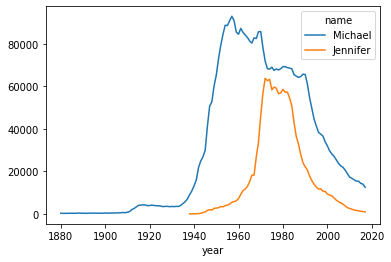

In [78]:
subset = total_births[["Michael", "Jennifer"]]
subset.plot()

# Exercises

## Q3: unique names

how many unique names appear in our top 1000 list?  Use the `.unique()` method on the "name" `Series` to get a an array (it will actually be a NumPy `ndarray` of objects)

In [94]:
# Albert
top_unique_names = top['name'].unique()
print(len(top_unique_names))

7134


## Q4: gender neutral names

What are all the names that appear for both boys and girls?

In [106]:
# Albert
def male_and_female(group):
    genders = group['sex'].values
    if 'M' in genders and 'F' in genders: return group['name']

unisex_names = names.groupby(['name']).apply(male_and_female)
print(unisex_names)

KeyboardInterrupt: 

## Q5: name diversity

We want to make a plot of how many names it takes to reach 50% of the births in a given year.  Let's start with the boys names:

In [108]:
boys = top[top.sex == "M"]

Now, to understand the process, let's work just on a particular year, 2015

In [109]:
b15 = boys[boys.year == 2015]

In [110]:
b15.info

<bound method DataFrame.info of                      name sex  births  year      prop
year sex                                             
2015 M   1845193     Noah   M   19613  2015  0.010270
         1845194     Liam   M   18355  2015  0.009611
         1845195    Mason   M   16610  2015  0.008697
         1845196    Jacob   M   15938  2015  0.008345
         1845197  William   M   15889  2015  0.008320
...                   ...  ..     ...   ...       ...
         1846188   Reagan   M     206  2015  0.000108
         1846189     Ayan   M     204  2015  0.000107
         1846190   Camren   M     204  2015  0.000107
         1846191  Deshawn   M     204  2015  0.000107
         1846192  Jayvion   M     204  2015  0.000107

[1000 rows x 5 columns]>

We'll use the `cumsum()` property to do a cumulative sum over the `prop` column we added previously

In [111]:
prop_cumsum = b15.sort_values(by="prop", ascending=False)["prop"].cumsum()

and now we can use `searchsorted` to return the position where "if the corresponding elements in v were inserted before the indices, the order of self would be preserved." (see http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.searchsorted.html)

In [112]:
prop_cumsum.searchsorted(0.5)

134

Since we start counting at 0, we add 1 to this to get the number of names needed in this year to reach 50% of births.

Now generalize this to a function that you can use `apply()` on and make a plot of the number of names to reach 50% by year

<AxesSubplot:xlabel='year'>

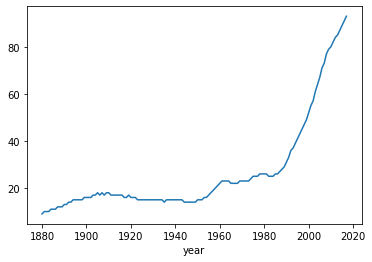

In [114]:
# Albert
def get_n50(group):
    prop_cumsum = group.sort_values(by='prop', ascending=False)['prop'].cumsum()
    return prop_cumsum.searchsorted(0.5)

n50 = names.groupby('year').apply(get_n50)
n50.plot()